# <center> Creating Multi Task Deep Learning Models With Keras </center>

In [ ]:
%matplotlib inline
%load_ext tensorboard

# import the required libraries

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
    shutil.rmtree('logs')
except:
    pass

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Now Create a New Dataset By Modifing The Existing Dataset

In [ ]:
# load the traning and testing data from the keras library

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
# This function will create noice in the grayscale images with the predominate colour as either red or blue

def create_example(x, y):
    # choise the predominant colour as random
    c = np.random.randint(0, 2)

    # create a image with noice
    image = 0.5 * np.random.rand(28, 28, 3)

    # add the grayscale image into the noice image
    image[:, :, c] += 0.5 *x / 255
    return image, y, c

digit : 0, color: red


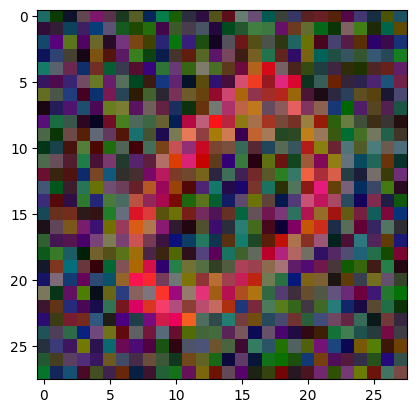

In [ ]:
# dictionary with colour information
colors = {0: 'red', 1 : "green"}

# let's see an example
x, y, c = create_example(x_train[1], y_train[1])
print(f'digit : {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

## Now Create The Dataset Generator Function To Generate a Batch of Example

In [ ]:
# This function will generate a batch at random
# This is a generator function, each time it is call, it will generate a batch at random

def generate_data(x, y, batch_size = 32):
    num_examples = len(y)

    while True :
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color

        yield x_batch, [y_batch, c_batch]

In [ ]:
# generate an example

x, [y, c] = next(generate_data(x_test, y_test, 1))

[3.] [0.]


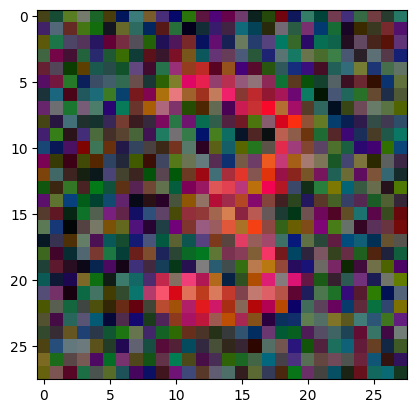

In [ ]:
# show the result

print(y,c)
plt.imshow(x[0])

## Create Model

In [ ]:
# import the required layers
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

# First the input layer
input_ = Input(shape=(28,28,3), name = 'input')

# First convolution layer
conv_1 = Conv2D(32, 3,  name = 'conv_1')(input_)
# activation layer
act_1 = Activation('relu', name = 'act_1')(conv_1)

# Maxpool layer
pool_1 = MaxPool2D(4,name = 'pool_1')(act_1)
# Flatten layer
flat_1 = Flatten(name = 'flat_1')(pool_1)

# First Output Layer
color =  Dense(1,activation = 'sigmoid', name = 'color')(flat_1)

# Second convolution layer
conv_2 = Conv2D(32, 3, padding = 'same', name = 'conv_2')(act_1)
# activation layer
act_2 = Activation("relu", name='act_2')(conv_2)

# Third convolution layer
conv_3 = Conv2D(32, 3, padding = 'same', name = 'conv_3')(act_2)

# Add Layer :
# connect the first convolution layer's output with the output of the thired convolution layer and add both.
add = Add(name = 'add')([act_1, conv_3])

# activation layer
act_3 = Activation("relu", name='act_3')(add)

# maxpool layer
pool_2 = MaxPool2D(4, name = 'pool_2')(act_3)
# flatten layer
flat_2 = Flatten(name = "flat_2")(pool_2)

# Our Secound Output layers
digit = Dense(10, activation = 'softmax', name = 'digit')(flat_2)

# Create the model
model = tf.keras.models.Model(input_, [digit, color])

# Compile the model
model.compile(
              # since we have two output layer, we can define two loss function
              loss = {
                  'digit' : 'sparse_categorical_crossentropy',
                  'color' : 'binary_crossentropy'
              },
              optimizer = 'adam',
              metrics = ['accuracy']
)

# To view the model architecture
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_1 (Conv2D)           │ (None, 26, 26, 32)     │            896 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 26, 26, 32)     │              0 │ conv_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_2 (Conv2D)           │ (None, 26, 26, 32)     │          9,248 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_2 (Activation)        │ (None, 26, 26, 32)     │              0 │ conv_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_3 (Conv2D)           │ (None, 26, 26, 32)     │          9,248 │ act_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 26, 26, 32)     │              0 │ act_1[0][0],           │
│                           │                        │                │ conv_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_3 (Activation)        │ (None, 26, 26, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool_2 (MaxPooling2D)     │ (None, 6, 6, 32)       │              0 │ act_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool_1 (MaxPooling2D)     │ (None, 6, 6, 32)       │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat_2 (Flatten)          │ (None, 1152)           │              0 │ pool_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat_1 (Flatten)          │ (None, 1152)           │              0 │ pool_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ digit (Dense)             │ (None, 10)             │         11,530 │ flat_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ color (Dense)             │ (None, 1)              │          1,153 │ flat_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,075 (125.29 KB)

 Trainable params: 32,075 (125.29 KB)

 Non-trainable params: 0 (0.00 B)

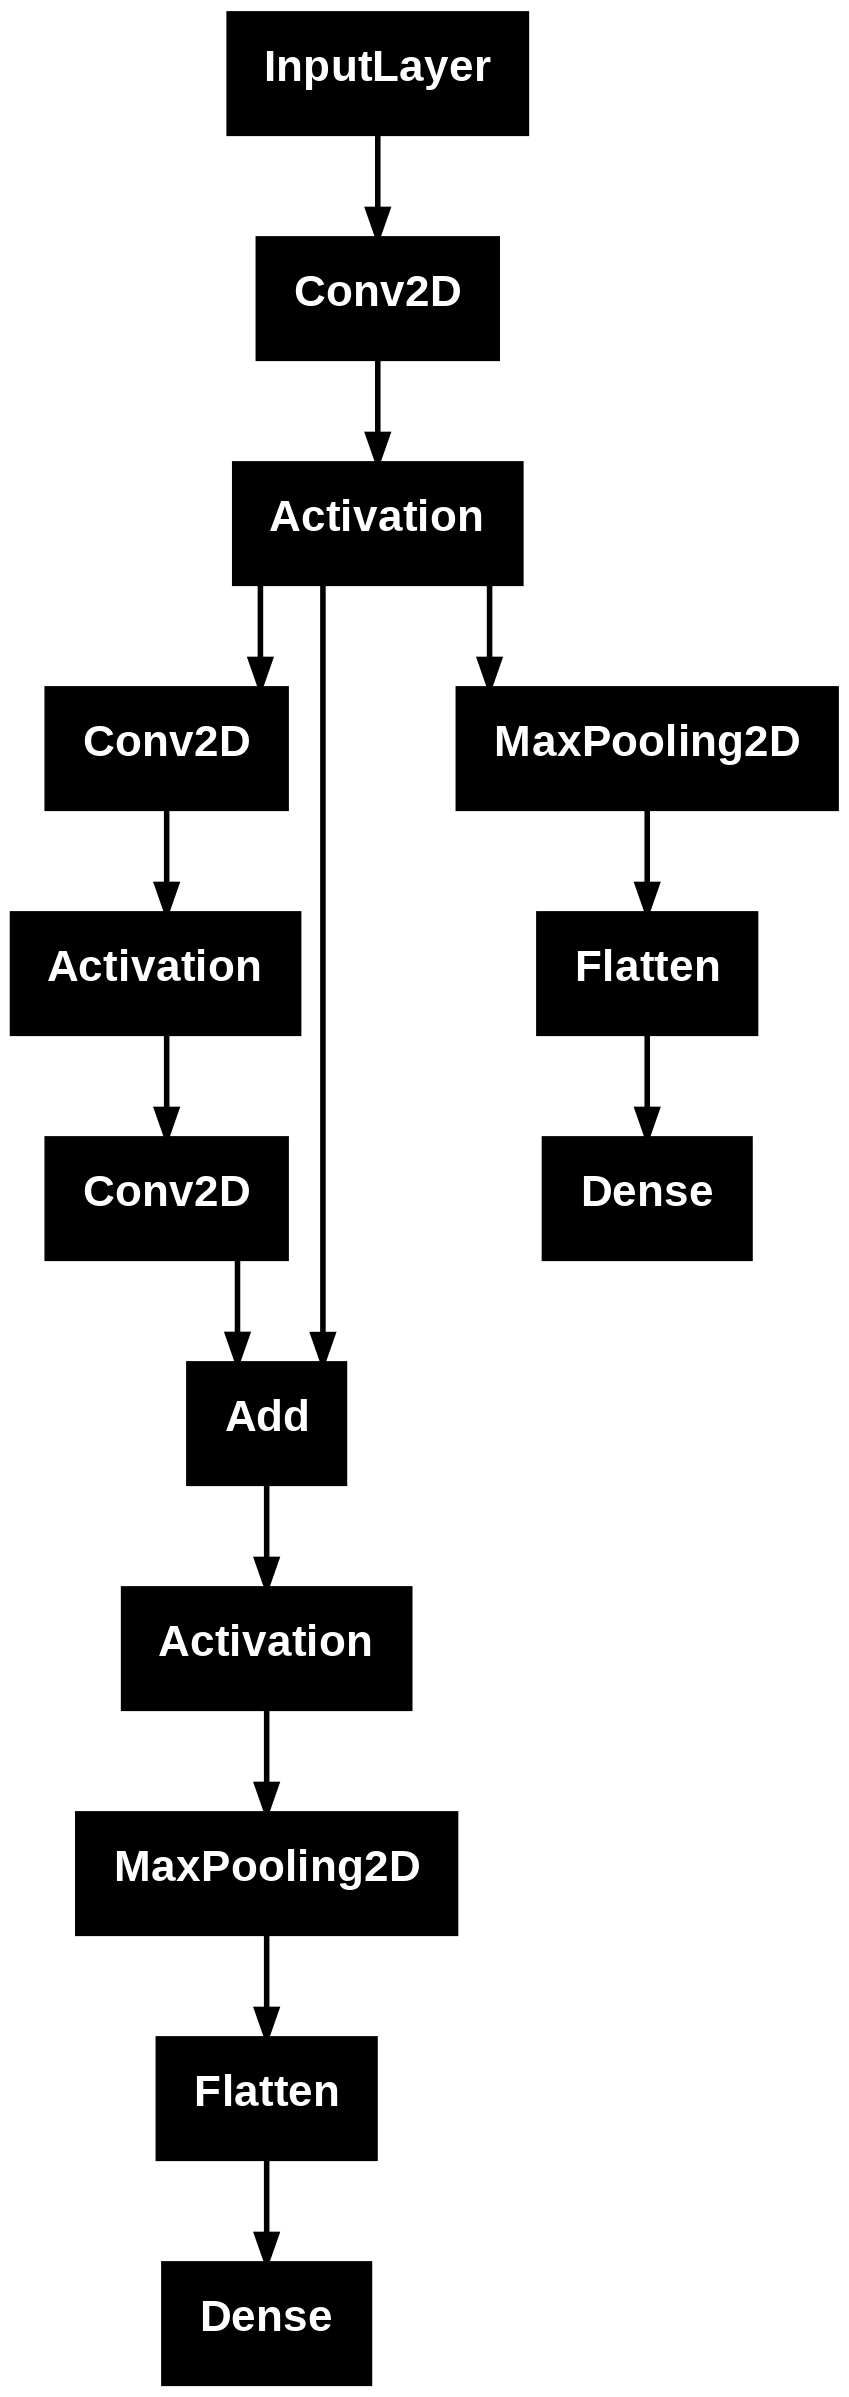

In [ ]:
# To View the neural network layout/connection
tf.keras.utils.plot_model(model)

## Training the Model

In [ ]:
# Since we have two output layers, we have to use custom class to generate/print the log

class Logger(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        # get the output accuracy
        digit_accuracy = logs.get('digit_accuracy')
        color_accuracy = logs.get('color_accuracy')

        # get the verbos accuracy
        val_digit_accuracy = logs.get('val_digit_accuracy')
        val_color_accuracy = logs.get('val_color_accuracy')

        # print the log
        print('='*30, epoch + 1, '='*30)
        print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
        print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [ ]:
# Generate the test and train data set
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)

# fit the model on the train dataset
_ = model.fit(
    train_gen,
    validation_data = test_gen,
    steps_per_epoch = 250,
    validation_steps = 100,
    epochs = 20,
    callbacks = [
                 Logger(),
                 tf.keras.callbacks.TensorBoard(log_dir = './logs')
    ],
    verbose = False

)

## Predictions

In [ ]:
# this function will test the model on the test dataset

def test_model(show=True):
    # generate the test data (1 at a time)
    x, [y, c] = next(test)

    # predict the model on test batch
    preds = model.predict(x)
    pred_digit = np.argmax(preds[0])
    pred_color = int(preds[1] > 0.5)

    # actual output
    gt_digit = int(y[0])
    gt_color = int(c[0])

    # show/display the image
    plt.imshow(x[0])

    if show:
        print(f'GT: {gt_digit}, {colors[gt_color]}')
        print(f'Pr: {pred_digit}, {colors[pred_color]}')
        plt.show()
    else:
        # show with green colour if the prediction is correct
        # show with red colour if the prediction is wrong
        col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
        plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
        plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
        plt.xticks([])
        plt.yticks([])

test = generate_data(x_test, y_test, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
GT: 4, red
Pr: 1, green


<ipython-input-93-b6718d5b9a40>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)


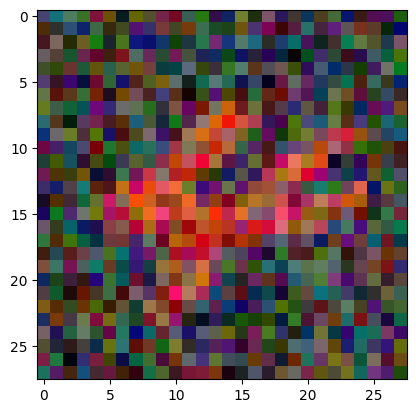

In [ ]:
test_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

<ipython-input-93-b6718d5b9a40>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


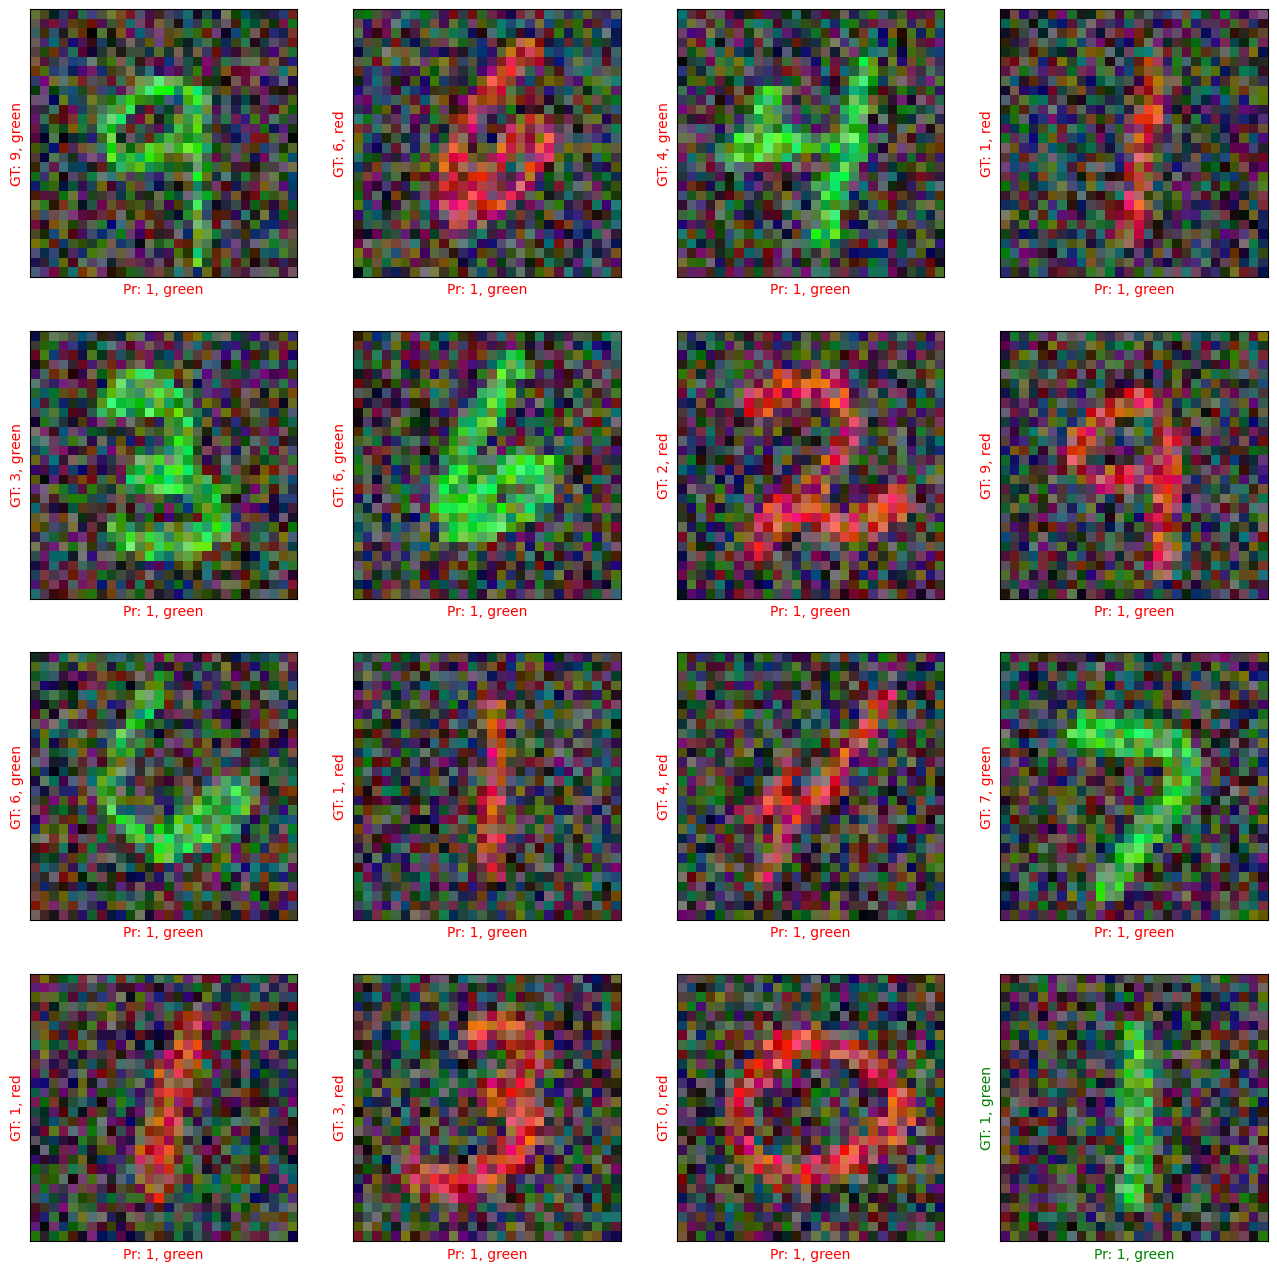

In [ ]:
# Generate in a 4x4 matrix

plt.figure(figsize = (16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    test_model(show = False)
plt.show()